In [1]:
import copy
import sqlite3
import numpy as np
import pandas as pd
from rdkit import Chem

#### 1. Extracting data from Database

In [2]:
def call_my_query(db_file, my_query):
    ## connect to the SQLIte database
    my_connection = sqlite3.connect(db_file)

    ## create a cursor object
    my_cursor = my_connection.cursor()

    ## excute the query
    my_cursor.execute(my_query)

    ## fetch all the rows
    rows = my_cursor.fetchall()
    
    ## export the results
    data_list = [row for row in rows]

    my_connection.close()
    return data_list

def extract_tables(db_file, table_name):
    ## extract table data from SQLite DB
    my_query_colName = f"PRAGMA table_info({table_name})"
    colName_list = call_my_query(db_file, my_query_colName)

    my_query_data = f"SELECT * FROM {table_name}"
    data_list = call_my_query(db_file, my_query_data)

    ## clean up data
    dataDict = {}
    for row_tuple in data_list:
        idx = row_tuple[0]
        dataDict[idx] = {}

        for col in colName_list:
            colIdx, colName = col[0], col[1]
            dataDict[idx][colName] = row_tuple[colIdx]
    return dataDict

In [3]:
db_file = './results/Compounds_All.mmpdb'
dataDict_tables = {}

for table_name in ["pair", "compound", "compound_property", "property_name", "constant_smiles",
                   "rule", "rule_smiles", "rule_environment", "rule_environment_statistics", "environment_fingerprint"]:
    dataDict_table = extract_tables(db_file, table_name)
    dataDict_tables[table_name] = pd.DataFrame.from_dict(dataDict_table).T
    # print(table_name)

#### 2. clean up data

In [4]:
dataTable = copy.deepcopy(dataDict_tables["pair"])
dataTable.head(3)

## ------------------- add compound structure & property data -------------------
table_merge = dataDict_tables["compound"]

## compound-1 (from)
dataTable = dataTable.merge(table_merge, left_on=['compound1_id'], right_on=['id'])
dataTable.drop(columns=['id_y', 'clean_smiles', 'clean_num_heavies'], inplace=True)
dataTable.rename(columns={'id_x':'id', 'public_id':'KT_number_1', 'input_smiles':'smiles_1'}, inplace=True)

## compound-2 (to)
dataTable = dataTable.merge(table_merge, left_on=['compound2_id'], right_on=['id'])
dataTable.drop(columns=['id_y', 'clean_smiles', 'clean_num_heavies'], inplace=True)
dataTable.rename(columns={'id_x':'id', 'public_id':'KT_number_2', 'input_smiles':'smiles_2'}, inplace=True)

## ------------------- add compound prop data -------------------
table_merge = dataDict_tables["compound_property"]

## compound-1 (from)
dataTable = dataTable.merge(table_merge, left_on=['compound1_id'], right_on=['compound_id'])
dataTable.drop(columns=['id_y', 'compound_id'], inplace=True)
dataTable.rename(columns={'id_x':'id', 'value':'property_values_1'}, inplace=True)

## compound-2 (to)
dataTable = dataTable.merge(table_merge, left_on=['compound2_id', 'property_name_id'], right_on=['compound_id', 'property_name_id'])
dataTable.drop(columns=['id_y', 'compound_id'], inplace=True)
dataTable.rename(columns={'id_x':'id', 'value':'property_values_2'}, inplace=True)

## add property name
table_merge = dataDict_tables["property_name"]
dataTable = dataTable.merge(table_merge, left_on=['property_name_id'], right_on=['id'])
dataTable.drop(columns=['id_y'], inplace=True)
dataTable.rename(columns={'id_x':'id', 'name':'property_name'}, inplace=True)

## ------------------- add constant pieces data of the match pair -------------------
table_merge = dataDict_tables["constant_smiles"]
dataTable = dataTable.merge(table_merge, left_on=['constant_id'], right_on=['id'])
dataTable.drop(columns=['id_y'], inplace=True)
dataTable.rename(columns={'id_x':'id', 'smiles':'constant_smiles'}, inplace=True)

## ------------------- add rule env data -------------------
table_merge = dataDict_tables["rule_environment"]
dataTable = dataTable.merge(table_merge, left_on=['rule_environment_id'], right_on=['id'])
dataTable.drop(columns=['id_y'], inplace=True)
dataTable.rename(columns={'id_x':'id', 'radius':'rule_env_radius', 'num_pairs':'rule_env_num_pairs'}, inplace=True)

## ------------------- add rule info -------------------
table_merge = dataDict_tables["rule"]
dataTable = dataTable.merge(table_merge, left_on=['rule_id'], right_on=['id'])
dataTable.drop(columns=['id_y'], inplace=True)    #'rule_id'
dataTable.rename(columns={'id_x':'id'}, inplace=True)

table_merge = dataDict_tables["rule_smiles"]
dataTable = dataTable.merge(table_merge, left_on=['from_smiles_id'], right_on=['id'])
dataTable.drop(columns=['id_y', 'from_smiles_id', 'num_heavies'], inplace=True)    #'num_heavies'
dataTable.rename(columns={'id_x':'id', 'smiles':'rule_from_smiles'}, inplace=True)

table_merge = dataDict_tables["rule_smiles"]
dataTable = dataTable.merge(table_merge, left_on=['to_smiles_id'], right_on=['id'])
dataTable.drop(columns=['id_y', 'to_smiles_id', 'num_heavies'], inplace=True)
dataTable.rename(columns={'id_x':'id', 'smiles':'rule_to_smiles'}, inplace=True)

## ------------------- add rule env stats -------------------
table_merge = dataDict_tables["rule_environment_statistics"]
dataTable = dataTable.merge(table_merge, 
                            left_on=['rule_environment_id', 'property_name_id'], 
                            right_on=['rule_environment_id', 'property_name_id'])

drop_cols = ['kurtosis', 'skewness', 'paired_t', 'p_value', 'q1', 'q3', 'median', 'std']
dataTable.drop(columns=['id_y']+drop_cols, inplace=True)
dataTable.rename(columns={'id_x':'id', 'count':'rule_env_count', 'avg':'rule_env_avg', 
                          'min':'rule_env_min', 'max':'rule_env_max'}, inplace=True)

## ------------------- add rule env environment_fingerprint data -------------------
table_merge = dataDict_tables["environment_fingerprint"]
## to be added

## ------------------- remove useless cols -------------------
dataTable.drop(columns=['id', 'compound1_id', 'compound2_id', 'constant_id', 'rule_environment_id', 'property_name_id'], inplace=True)
print(dataTable.shape)
dataTable.head(3)

(1857222, 18)


,KT_number_1,smiles_1,KT_number_2,smiles_2,property_values_1,property_values_2,property_name,constant_smiles,rule_id,environment_fingerprint_id,rule_env_radius,rule_env_num_pairs,rule_from_smiles,rule_to_smiles,rule_env_count,rule_env_avg,rule_env_min,rule_env_max
0,KT-0013567,Clc1ccc(cc1)/C=C/2\C=C(N(C2=O)c3ccc(cc3)NC(=O)...,KT-0013672,[N+](=O)([O-])c1ccc(cc1)/C=C/2\C=C(N(C2=O)c3cc...,4.74391,4.26768,logD_CDD,[*:1]/C=C1/C=C(c2ccccc2)N(c2ccc(NC(C)=O)cc2)C1=O,1,1,0,1,[*:1]c1ccc(Cl)cc1,[*:1]c1ccc([N+](=O)[O-])cc1,1.0,-0.47623,-0.47623,-0.47623
1,KT-0013567,Clc1ccc(cc1)/C=C/2\C=C(N(C2=O)c3ccc(cc3)NC(=O)...,KT-0013672,[N+](=O)([O-])c1ccc(cc1)/C=C/2\C=C(N(C2=O)c3cc...,4.74391,4.26768,logD_CDD,[*:1]/C=C1/C=C(c2ccccc2)N(c2ccc(NC(C)=O)cc2)C1=O,1,2,1,1,[*:1]c1ccc(Cl)cc1,[*:1]c1ccc([N+](=O)[O-])cc1,1.0,-0.47623,-0.47623,-0.47623
2,KT-0013567,Clc1ccc(cc1)/C=C/2\C=C(N(C2=O)c3ccc(cc3)NC(=O)...,KT-0013672,[N+](=O)([O-])c1ccc(cc1)/C=C/2\C=C(N(C2=O)c3cc...,4.74391,4.26768,logD_CDD,[*:1]/C=C1/C=C(c2ccccc2)N(c2ccc(NC(C)=O)cc2)C1=O,1,3,2,1,[*:1]c1ccc(Cl)cc1,[*:1]c1ccc([N+](=O)[O-])cc1,1.0,-0.47623,-0.47623,-0.47623


In [5]:
################################################################################################
## generate "pair id" for each pairs
def GeneratePairID(row, col_mol_id_1='KT_number_1', col_mol_id_2='KT_number_2'):
    mol_id_1 = row[col_mol_id_1]
    mol_id_2 = row[col_mol_id_2]
    pair_id = str(mol_id_1) + '=>' + str(mol_id_2)
    
    mol_id_1_num = int(str(mol_id_1).split('-')[1])
    mol_id_2_num = int(str(mol_id_2).split('-')[1])
    pair_couple = (np.min([mol_id_1_num, mol_id_2_num]), np.max([mol_id_1_num, mol_id_2_num]))
    return pd.Series([pair_id, pair_couple])

dataTable[['Pair_id', 'PairInfo']] = dataTable.apply(lambda row: GeneratePairID(row, col_mol_id_1='KT_number_1', col_mol_id_2='KT_number_2'), axis=1)
print(dataTable.shape)

################################################################################################
## calculate the size (N heavy atoms) of the constant piece
def calculate_heavy_atoms(molecule_smiles):
    try:
        mol = Chem.MolFromSmiles(molecule_smiles)
        num_heavy_atoms = mol.GetNumHeavyAtoms()
    except Exception as e:
        print('Error', e)
        num_heavy_atoms = np.nan
    return num_heavy_atoms

dataTable['constant_size'] = dataTable['constant_smiles'].apply(calculate_heavy_atoms)
dataTable.sort_values(by=['PairInfo', 'Pair_id', 'rule_env_radius', 'constant_size'], ascending=[True, True, True, False], inplace=True)
print(dataTable.shape)

################################################################################################

(1857222, 20)
(1857222, 21)


In [6]:
dataTable.to_csv(f'./results/Compounds_All_4_informatics.csv', index=False)
dataTable.head(3)

,KT_number_1,smiles_1,KT_number_2,smiles_2,property_values_1,property_values_2,property_name,constant_smiles,rule_id,environment_fingerprint_id,...,rule_env_num_pairs,rule_from_smiles,rule_to_smiles,rule_env_count,rule_env_avg,rule_env_min,rule_env_max,Pair_id,PairInfo,constant_size
64546,KT-0000031,F[C@H](CNC(=O)c1cnc(cc1NC2CC2)Nc4nc3c(cncc3)cc...,KT-0000032,F[C@@H]([C@@H](O)C)CNC(=O)c1cnc(cc1NC2CC2)Nc4n...,2.08638,1.60852,logD_CDD,[*:1][C@@](C)(O)[C@H](F)CNC(=O)c1cnc(Nc2ccc3cn...,1073,1,...,1034,[*:1]C,[*:1][H],1034.0,-0.270035,-2.95251,1.12564,KT-0000031=>KT-0000032,"(31, 32)",30
1474868,KT-0000031,F[C@H](CNC(=O)c1cnc(cc1NC2CC2)Nc4nc3c(cncc3)cc...,KT-0000032,F[C@@H]([C@@H](O)C)CNC(=O)c1cnc(cc1NC2CC2)Nc4n...,2.08638,1.60852,logD_CDD,[*:1]C.[*:2]O.[*:3][C@H](F)CNC(=O)c1cnc(Nc2ccc...,28826,25,...,16,[*:1]C([*:2])([*:3])C,[*:1]C([*:2])[*:3],16.0,-0.230068,-1.10310,0.62476,KT-0000031=>KT-0000032,"(31, 32)",29
482143,KT-0000031,F[C@H](CNC(=O)c1cnc(cc1NC2CC2)Nc4nc3c(cncc3)cc...,KT-0000032,F[C@@H]([C@@H](O)C)CNC(=O)c1cnc(cc1NC2CC2)Nc4n...,2.08638,1.60852,logD_CDD,[*:1]C.[*:2][C@H](F)CNC(=O)c1cnc(Nc2ccc3cnccc3...,55832,8,...,3,[*:1]C([*:2])(C)O,[*:1]C([*:2])O,3.0,-0.224377,-0.47786,0.28259,KT-0000031=>KT-0000032,"(31, 32)",28


In [45]:
num_0 = 0
num_1 = 0
num_2 = 0
num_3more = 0
for cid_set in dataTable['PairInfo'].unique():
    dataTable_cset = dataTable[dataTable['PairInfo']==cid_set]

    unique_pairs = dataTable_cset['Pair_id'].unique()

    if len(unique_pairs) <= 0:
        num_0 += 1
    elif len(unique_pairs) == 1:
        num_1 += 1
    elif len(unique_pairs) == 2:
        num_2 += 1
    else:
        num_3more += 1

#### 3. removed the "duplicated" rows

In [28]:
dataTable_radiu0 = dataTable[dataTable['rule_env_radius']==0].reset_index(drop=True)
print(dataTable_radiu0.shape)

dataDict_mmps = {}

## loop all property
for prop in dataTable_radiu0['property_name'].unique():
    ## get all available data with this property in this cid-set
    dataTable_prop = dataTable_radiu0[dataTable_radiu0['property_name']==prop]
    print(prop, ':', dataTable_prop.shape[0])

    ## loop all cid-sets
    for cid_set in dataTable_prop['PairInfo'].unique():
        ## get pair compound id 
        cid_1, cid_2 = f"KT-{cid_set[0]:07}", f"KT-{cid_set[1]:07}"
        pair_id_a, pair_id_b = f"{cid_1}=>{cid_2}", f"{cid_2}=>{cid_1}"

        ## get all available data with this cid-set
        dataTable_prop_pair = dataTable_prop[dataTable_prop['PairInfo']==cid_set]
        num_fragmentations = dataTable_prop_pair['constant_smiles'].unique()

        for const_smi in dataTable_prop_pair['constant_smiles'].unique():
            const_smi_list = const_smi.split('.')


            dataTable_prop_pair_cuts = dataTable_prop_pair[dataTable_prop_pair['constant_smiles']==const_smi]
            if dataTable_prop_pair_cuts.shape[0] > 2:
                print(prop, cid_1, cid_2, dataTable_prop_pair_cuts.shape[0])
                test_dataTable = dataTable_prop_pair_cuts


               
        # dataTable_prop_pair = dataTable_prop_pair.sort_values(by=['constant_size', 'Pair_id'], ascending=[False, True], inplace=False)
        
        # if dataTable_prop_pair.shape[0] > 2:
        #     print(prop, cid_1, cid_2, dataTable_prop_pair.shape[0])

        # ## if this pair-a is available
        # if pair_id_a in dataTable_prop_pair['Pair_id'].unique():
        #     dataTable_prop_pair_a = dataTable_prop_pair[dataTable_prop_pair['Pair_id']==pair_id_a]
        #     dataTable_prop_pair_a

                    

        #     pass
        # else:
        #     pass
        
        # ## if this pair-b is available
        # if pair_id_b in dataTable_prop_pair['Pair_id'].unique():
        #     dataTable_prop_pair_b = dataTable_prop_pair[dataTable_prop_pair['Pair_id']==pair_id_b]
        #     pass
        # else:
        #     pass


(309537, 21)
logD_CDD : 260471
logD_CDD KT-0000031 KT-0000032 3
logD_CDD KT-0000031 KT-0000032 3
logD_CDD KT-0000031 KT-0000032 3
logD_CDD KT-0000031 KT-0000032 3
logD_CDD KT-0000031 KT-0000032 3
logD_CDD KT-0000031 KT-0000032 3
logD_CDD KT-0000031 KT-0000055 3
logD_CDD KT-0000031 KT-0000100 3
logD_CDD KT-0000031 KT-0000100 3
logD_CDD KT-0000031 KT-0000100 3
logD_CDD KT-0000031 KT-0000100 3
logD_CDD KT-0000031 KT-0000100 3
logD_CDD KT-0000031 KT-0000100 3
logD_CDD KT-0000058 KT-0005744 5
logD_CDD KT-0000058 KT-0005849 4
logD_CDD KT-0000058 KT-0014250 5
logD_CDD KT-0000058 KT-0014251 4
logD_CDD KT-0000058 KT-0014349 6
logD_CDD KT-0000058 KT-0014349 6


KeyboardInterrupt: 

In [44]:
dataTable_prop[(dataTable_prop['Pair_id']=='KT-0000058=>KT-0014349')]

,KT_number_1,smiles_1,KT_number_2,smiles_2,property_values_1,property_values_2,property_name,constant_smiles,rule_id,environment_fingerprint_id,...,rule_env_num_pairs,rule_from_smiles,rule_to_smiles,rule_env_count,rule_env_avg,rule_env_min,rule_env_max,Pair_id,PairInfo,constant_size
259,KT-0000058,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,KT-0014349,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,0.295147,1.71234,logD_CDD,[*:1]C.[*:3]C.[*:2]C(=O)N1C[C@H](O)C[C@H]1C(=O...,29524,25,...,3,[*:1]C(=O)N[C@H]([*:2])C([*:3])(C)C,[*:1]Oc1cc(C([*:2])C([*:3])C)on1,3.0,1.456549,1.417193,1.476228,KT-0000058=>KT-0014349,"(58, 14349)",26
261,KT-0000058,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,KT-0014349,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,0.295147,1.71234,logD_CDD,[*:1]C.[*:3]C.[*:2]C(=O)N1C[C@H](O)C[C@H]1C(=O...,29525,25,...,3,[*:1]C(=O)N[C@H]([*:2])C([*:3])(C)C,[*:1]Oc1cc(C([*:2])[C@H]([*:3])C)on1,3.0,1.456549,1.417193,1.476228,KT-0000058=>KT-0014349,"(58, 14349)",26
263,KT-0000058,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,KT-0014349,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,0.295147,1.71234,logD_CDD,[*:1]C.[*:3]C.[*:2]C(=O)N1C[C@H](O)C[C@H]1C(=O...,29526,25,...,3,[*:1]C(=O)N[C@H]([*:2])C([*:3])(C)C,[*:1]Oc1cc(C([*:2])[C@@H]([*:3])C)on1,3.0,1.456549,1.417193,1.476228,KT-0000058=>KT-0014349,"(58, 14349)",26
265,KT-0000058,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,KT-0014349,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,0.295147,1.71234,logD_CDD,[*:1]C.[*:2]C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1cc...,27454,8,...,3,[*:1]C(=O)N[C@H]([*:2])C(C)(C)C,[*:2]C(c1cc(OC)no1)[C@H]([*:1])C,3.0,1.456549,1.417193,1.476228,KT-0000058=>KT-0014349,"(58, 14349)",25
267,KT-0000058,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,KT-0014349,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,0.295147,1.71234,logD_CDD,[*:1]C.[*:2]C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1cc...,27455,8,...,3,[*:1]C(=O)N[C@H]([*:2])C(C)(C)C,[*:2]C(c1cc(OC)no1)[C@@H]([*:1])C,3.0,1.456549,1.417193,1.476228,KT-0000058=>KT-0014349,"(58, 14349)",25
269,KT-0000058,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,KT-0014349,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,0.295147,1.71234,logD_CDD,[*:1]C.[*:2]C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1cc...,27456,8,...,3,[*:1]C(=O)N[C@H]([*:2])C(C)(C)C,[*:1]Oc1cc(C([*:2])C(C)C)on1,3.0,1.456549,1.417193,1.476228,KT-0000058=>KT-0014349,"(58, 14349)",25
271,KT-0000058,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,KT-0014349,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,0.295147,1.71234,logD_CDD,[*:1]C.[*:2]C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1cc...,27453,8,...,3,[*:1]C(=O)N[C@H]([*:2])C(C)(C)C,[*:1]C(C)C([*:2])c1cc(OC)no1,3.0,1.456549,1.417193,1.476228,KT-0000058=>KT-0014349,"(58, 14349)",25


In [39]:
test_dataTable['constant_smiles'][265].split('.')[0]

'[*:1]C'

In [41]:
calculate_heavy_atoms(test_dataTable['constant_smiles'][265].split('.')[0])

1

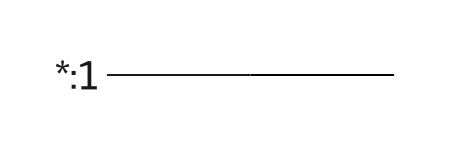

In [40]:
Chem.MolFromSmiles(test_dataTable['constant_smiles'][265].split('.')[0]).

In [42]:
test_dataTable

,KT_number_1,smiles_1,KT_number_2,smiles_2,property_values_1,property_values_2,property_name,constant_smiles,rule_id,environment_fingerprint_id,...,rule_env_num_pairs,rule_from_smiles,rule_to_smiles,rule_env_count,rule_env_avg,rule_env_min,rule_env_max,Pair_id,PairInfo,constant_size
265,KT-0000058,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,KT-0014349,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,0.295147,1.712340,logD_CDD,[*:1]C.[*:2]C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1cc...,27454,8,...,3,[*:1]C(=O)N[C@H]([*:2])C(C)(C)C,[*:2]C(c1cc(OC)no1)[C@H]([*:1])C,3.0,1.456549,1.417193,1.476228,KT-0000058=>KT-0014349,"(58, 14349)",25
267,KT-0000058,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,KT-0014349,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,0.295147,1.712340,logD_CDD,[*:1]C.[*:2]C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1cc...,27455,8,...,3,[*:1]C(=O)N[C@H]([*:2])C(C)(C)C,[*:2]C(c1cc(OC)no1)[C@@H]([*:1])C,3.0,1.456549,1.417193,1.476228,KT-0000058=>KT-0014349,"(58, 14349)",25
269,KT-0000058,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,KT-0014349,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,0.295147,1.712340,logD_CDD,[*:1]C.[*:2]C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1cc...,27456,8,...,3,[*:1]C(=O)N[C@H]([*:2])C(C)(C)C,[*:1]Oc1cc(C([*:2])C(C)C)on1,3.0,1.456549,1.417193,1.476228,KT-0000058=>KT-0014349,"(58, 14349)",25
271,KT-0000058,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,KT-0014349,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,0.295147,1.712340,logD_CDD,[*:1]C.[*:2]C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1cc...,27453,8,...,3,[*:1]C(=O)N[C@H]([*:2])C(C)(C)C,[*:1]C(C)C([*:2])c1cc(OC)no1,3.0,1.456549,1.417193,1.476228,KT-0000058=>KT-0014349,"(58, 14349)",25
283,KT-0014349,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,KT-0000058,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,1.712340,0.295147,logD_CDD,[*:1]C.[*:2]C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1cc...,27469,8,...,3,[*:1]C(C)C([*:2])c1cc(OC)no1,[*:2][C@@H](NC(C)=O)C([*:1])(C)C,3.0,-1.456549,-1.476228,-1.417193,KT-0014349=>KT-0000058,"(58, 14349)",25
285,KT-0014349,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,KT-0000058,s1cnc(c1-c2ccc(cc2)CNC(=O)[C@H]3N(C[C@@H](C3)O...,1.712340,0.295147,logD_CDD,[*:1]C.[*:2]C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1cc...,27472,8,...,3,[*:1]Oc1cc(C([*:2])C(C)C)on1,[*:2][C@@H](NC(C)=O)C([*:1])(C)C,3.0,-1.456549,-1.476228,-1.417193,KT-0014349=>KT-0000058,"(58, 14349)",25


In [8]:
unique_cid_1 = dataTable_radiu0['KT_number_1'].unique()
print(len(unique_cid_1))

unique_cid_2 = dataTable_radiu0['KT_number_2'].unique()
print(len(unique_cid_2))

unique_pair_set = dataTable_radiu0['PairInfo'].unique()
print(len(unique_pair_set))

10982


In [18]:
f"KT-{unique_pair_set[0][0]:07}" in unique_cid_1

True

In [23]:
7990-4500-2677

813

In [ ]:
dataDict_mmps = {}


for idx in dataTable_radiu0.index:
    pair_info = dataTable_radiu0['PairInfo'][idx]
    pair_id = dataTable_radiu0['Pair_id'][idx]
    cid_1, cid_2 = dataTable_radiu0['KT_number_1'][idx], dataTable_radiu0['KT_number_2'][idx]
    
    if pair_info not in dataDict_mmps

In [ ]:
dataTable_radiu0 = dataTable[dataTable['rule_env_radius']==0].reset_index(drop=True)
print(dataTable_radiu0.shape)

dataTable_radiu0 = dataTable_radiu0.sort_values(by=['PairInfo', 'Pair_id', 'property_name', 'rule_env_radius', 'constant_size'], ascending=[True, True, False], inplace=False)
dataTable_rmDup = dataTable_radiu0.drop_duplicates(subset=['PairInfo', 'property_name'], keep='first', inplace=False)
dataTable_rmDup.to_csv(f'./results/Compounds_All_4_informatics_rmDups_raw.csv', index=False)
print(dataTable_rmDup.shape)
dataTable_rmDup.head(3)

#### append symetric rows

In [ ]:
dataTable_rmDup

In [ ]:
rename_symetric_dict = {
    'KT_number_1': 'KT_number_2',
    'smiles_1': 'smiles_2',
    'KT_number_2': 'KT_number_1',
    'smiles_2': 'smiles_1',
    'property_values_1': 'property_values_2',
    'property_values_2': 'property_values_1', 
    'rule_from_smiles': 'rule_to_smiles',
    'rule_to_smiles': 'rule_from_smiles'}
dataTable_rmDup_symetric = dataTable_rmDup.rename(columns=rename_symetric_dict, inplace=False)
dataTable_rmDup_symetric['Pair_id'] = dataTable_rmDup_symetric['KT_number_1'] + '=>' + dataTable_rmDup_symetric['KT_number_2']
for col in ['rule_env_avg', 'rule_env_min', 'rule_env_max']:
    dataTable_rmDup_symetric[col] = dataTable_rmDup_symetric[col] * -1
dataTable_rmDup_symetric.head(3)

In [ ]:
dataTable_rmDup_all = dataTable_rmDup._append(dataTable_rmDup_symetric, ignore_index=True)
dataTable_rmDup_all['rule_env_min'] = dataTable_rmDup_all['rule_env_min'].apply(lambda x:round(x, 2)).astype('str')
dataTable_rmDup_all['rule_env_max'] = dataTable_rmDup_all['rule_env_max'].apply(lambda x:round(x, 2)).astype('str')
dataTable_rmDup_all['rule_env_range'] = '('+ dataTable_rmDup_all['rule_env_min'] + ',' + dataTable_rmDup_all['rule_env_max'] +')'

In [ ]:
dataTable_rmDup_all.sort_values(by=['PairInfo', 'property_name', 'Pair_id'], ascending=[True, True, True], inplace=True)
dataTable_rmDup_all = dataTable_rmDup_all.reset_index(drop=True)
dataTable_rmDup_all

In [ ]:
dataTable_rmDup_all.to_csv(f'./results/Compounds_All_4_informatics_rmDups.csv', index=False)
